# Basic Features Model Training

## Introduction

In this phase, we will train baseline predictive models using XGBoost and LightGBM algorithms on the main application training dataset. These models will serve as the foundation for our subsequent analysis and feature engineering efforts.

By leveraging XGBoost and LightG , we aim to establish a solid baseline for predicting loan default risk. This initial modeling stage will provide valuable insights into the dataset's characteristics and help guide our feature engineering and model refinement processes.

## Training the Base model

Training and evaluating model: XGBoost
Fitting 3 folds for each of 4 candidates, totalling 12 fits


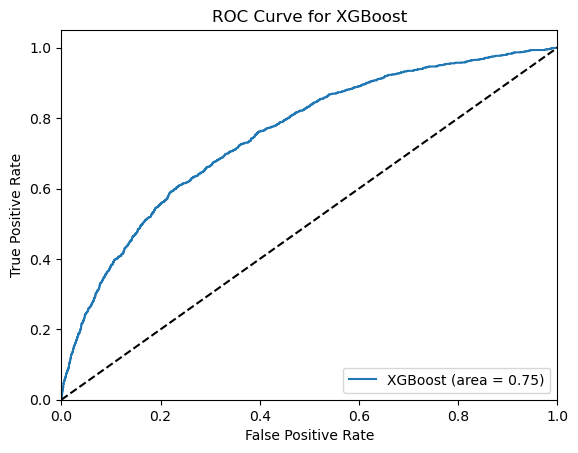

Performance Metrics for XGBoost:
Accuracy: 0.9205
Precision: 0.4776
Recall: 0.0263
F1 Score: 0.0498
ROC AUC: 0.7510



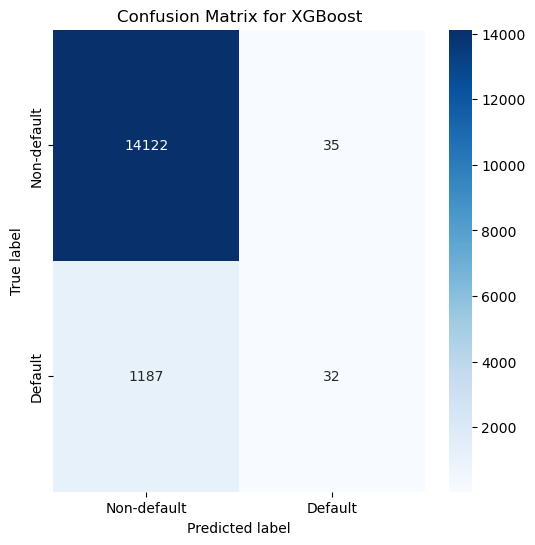

Training and evaluating model: LightGBM
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Number of positive: 4972, number of negative: 56530
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11267
[LightGBM] [Info] Number of data points in the train set: 61502, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080843 -> initscore=-2.430949
[LightGBM] [Info] Start training from score -2.430949


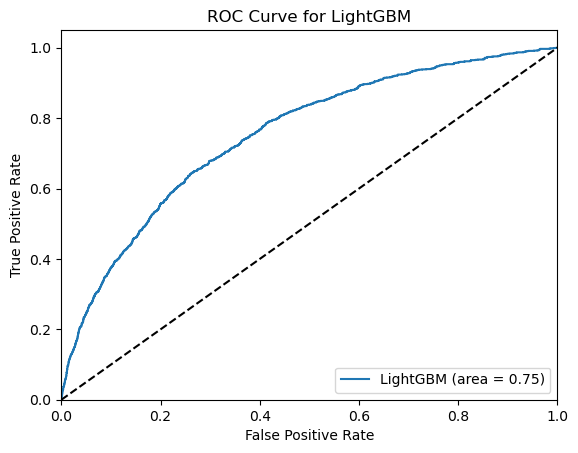

Performance Metrics for LightGBM:
Accuracy: 0.9205
Precision: 0.4727
Recall: 0.0213
F1 Score: 0.0408
ROC AUC: 0.7519



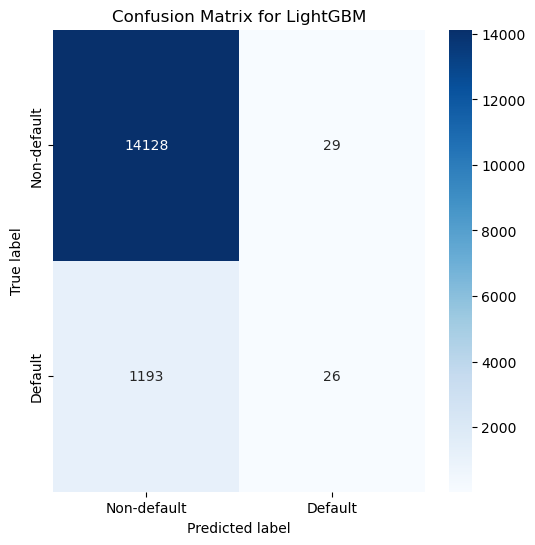

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

df = pd.read_csv('../data/original/application_train.csv').sample(frac=0.25, random_state=42)  # Sample data immediately to improve load time and memory usage
X = df.drop('TARGET', axis=1)
y = df['TARGET']

categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

models_params = {
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss'),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {
            'model__n_estimators': [100, 200],
            'model__num_leaves': [31, 41]
        }
    }
}

for name, mp in models_params.items():
    print(f"Training and evaluating model: {name}")
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', mp['model'])])

    clf = GridSearchCV(pipe, mp['params'], cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
    
    clf.fit(X_train, y_train)
    
    best_model = clf.best_estimator_

    y_scores = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Performance Metrics for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

## Conclusions

While both the XGBoost and LightGBM models demonstrate commendable accuracy in predicting non-default loans, their performance in identifying actual default cases falls significantly short. The low recall scores indicate that the models are struggling to effectively capture instances of loan default.

Improving the models' ability to predict default casit aligns directly with the primary objective of the project. Strategies such as feature engineeri andg, model tunims may be necessary to enhance the models' performance in identifying default risks accurately. 